# Move recommendations

In [13]:
import json
import subprocess
import sys

import chess.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [14]:
df = pd.read_parquet('data/moves_2025_01.parquet')
df.tail()

,avg_elo,moves,winner
4990819,1553.0,e2e4 d7d5 e4d5 d8d5 b1c3 d5e6 f1e2 b8c6 g1f3 g...,1
4990836,1960.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 c1e3 c8g4 f1e2 b...,1
4990890,817.5,e2e4 d7d5 e4d5 d8d5 d2d3 d5d4 c2c3 d4e5 f1e2 c...,2
4991060,1251.0,e2e4 d7d5 e4d5 d8d5 d2d4 g8f6 b1c3 g7g6 c3d5 f...,1
4991095,1889.5,e2e4 d7d5 e4d5 d8d5 g1f3 c8g4 f1e2 b8c6 e1g1 e...,1


In [15]:
def get_fen_after_n_moves(moves_str, n_moves=8):
    b = chess.Board()
    for mv in moves_str.split()[:n_moves]:
        b.push_uci(mv)
    return b.fen()


df["fen"] = df["moves"].apply(lambda x: get_fen_after_n_moves(x, 8))
df["next_move"] = df["moves"].apply(lambda x: x.split()[8] if len(x.split()) > 8 else None)
df_filtered = df.dropna(subset=["next_move"])
df_fen = df.copy()

df_positions = (
    df_filtered
    .groupby("fen")
    .agg(
        count=("next_move", "size"),
        white_wins=("winner", lambda x: (x == 1).sum())
    )
)

df_positions = df_positions.sort_values(by="count", ascending=False).reset_index()
df_positions.head()

,fen,count,white_wins
0,rnb1kbnr/ppp1pppp/8/8/8/2N5/PPPPqPPP/R1B1KBNR ...,2696,1267
1,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,2650,1259
2,r1b1kbnr/ppp1pppp/2n1q3/8/8/2N5/PPPPBPPP/R1BQK...,2116,1126
3,rnb1kbnr/ppp1pppp/6q1/8/8/2N5/PPPPBPPP/R1BQK1N...,1772,822
4,rnb1kb1r/ppp1pppp/4qn2/8/8/2N5/PPPPBPPP/R1BQK1...,1253,686


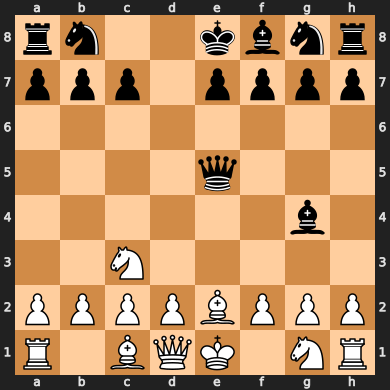

In [16]:
sample_game = df_positions.iloc[1]
chess.Board(sample_game["fen"])

In [17]:
print(f"Total games from this position: {sample_game["count"]}")
print(f"Win rate for White: {(sample_game["white_wins"] / sample_game["count"]):.2%}")

Total games from this position: 2650
Win rate for White: 47.51%


In [18]:
df_next_move = (
    df_filtered
    .groupby(["fen", "next_move"])
    .agg(
        avg_elo_mean=("avg_elo", lambda x: int(x.mean())),
        count=("next_move", "size"),
        white_wins=("winner", lambda x: (x == 1).sum())
    )
    .reset_index()
)

df_next_move = df_next_move[df_next_move["fen"] == sample_game["fen"]]
df_next_move

,fen,next_move,avg_elo_mean,count,white_wins
2674,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,b2b3,1237,5,3
2675,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,c3a4,934,1,0
2676,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,c3b5,1482,5,4
2677,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d3,1591,114,54
2678,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d4,1680,726,374
2679,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,e1f1,1878,2,2
2680,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f3,1503,720,351
2681,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f4,1544,4,0
2682,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1f3,1507,816,350
2683,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1h3,881,2,1


In [19]:
proc_ep = subprocess.run(
    [sys.executable, 'engine_play.py', sample_game["fen"]],
    capture_output=True,
    text=True
)

if proc_ep.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc_ep.stderr}")

engine_move = proc_ep.stdout
print(f"Best move recommended by the engine: {engine_move}")

Best move recommended by the engine: d2d4



In [20]:
fen = sample_game["fen"]
moves = str(df_next_move["next_move"].tolist())

proc = subprocess.run(
    [sys.executable, 'evaluate_engine.py', fen, moves],
    capture_output=True,
    text=True
)

if proc.returncode != 0:
    raise RuntimeError(f"Engine script failed: {proc.stderr}")

engine_results = json.loads(proc.stdout)
engine_df = pd.DataFrame(engine_results)

df_stats = df_next_move.merge(engine_df, on='next_move')
df_stats

,fen,next_move,avg_elo_mean,count,white_wins,delta,complexity
0,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,b2b3,1237,5,3,-15,0.243842
1,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,c3a4,934,1,0,-31,0.109606
2,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,c3b5,1482,5,4,17,0.147783
3,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d3,1591,114,54,8,0.262315
4,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,d2d4,1680,726,374,95,0.543103
5,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,e1f1,1878,2,2,-15,0.326355
6,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f3,1503,720,351,65,0.231527
7,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,f2f4,1544,4,0,22,0.256158
8,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1f3,1507,816,350,-57,0.467980
9,rn2kbnr/ppp1pppp/8/4q3/6b1/2N5/PPPPBPPP/R1BQK1...,g1h3,881,2,1,-19,0.247537


## Calculate score for the elo based recommendation
based on
* complexity: fragility score calculated in 'evaluate_engine.py' and contained in above table
* rating: delta of centipawn score for the next move (also contained in df_stats)
* winrate of historical games played by players with a similar elo: has to be done for each elo level we want to analyze

In [21]:
min_elo = int(df["avg_elo"].min())
max_elo = int(df["avg_elo"].max())
# sample_elos = random.sample(range(min_elo, max_elo + 1), 5)
sample_elos = [352, 630, 1102, 1590, 1923, 2332]
df_fen_filtered = df_fen[df_fen["fen"] == sample_game["fen"]]

ELO_DEVIATION = 500
COMPLEXITY_WEIGHT_MAX = 0.3  # dynamic
RATING_WEIGHT = 0.3

In [22]:
def analyze_moves(data_stats, data_fen, e):
    for mv in data_stats["next_move"].tolist():
        low = e - ELO_DEVIATION
        high = e + ELO_DEVIATION
        data_filtered = data_fen[(data_fen['avg_elo'].between(low, high)) & (data_fen["next_move"] == mv)]
        data_stats["winrate_" + str(elo)] = (
            (data_filtered["winner"] == 1).mean() if len(data_filtered) > 0 else 0.0
        )

    factor = max(0.0, (elo - 1000) / 1000)
    complexity_weight = max(0.0, COMPLEXITY_WEIGHT_MAX * (1 - factor))
    rating_weight = RATING_WEIGHT
    winrate_weight = 1 - complexity_weight - rating_weight

    scaler = MinMaxScaler()
    data_stats[['rating_scaled', 'complexity_scaled', 'winrate_scaled']] = scaler.fit_transform(
        data_stats[['delta', 'complexity', "winrate_" + str(elo)]]
    )
    data_stats['complexity_scaled'] = 1 - data_stats['complexity_scaled']

    data_stats["score_" + str(elo)] = (
            rating_weight * data_stats['rating_scaled'] +
            complexity_weight * data_stats['complexity_scaled'] +
            winrate_weight * data_stats['winrate_scaled']
    )

    best_mv = data_stats.sort_values("score_" + str(elo), ascending=False)["next_move"].iloc[0]
    return data_stats, best_mv


for elo in sorted(sample_elos):
    df_stats, best_move = analyze_moves(df_stats, df_fen_filtered, elo)
    print(f"Recommended move at Elo {elo}:\t{best_move}")

Recommended move at Elo 352:	f2f3
Recommended move at Elo 630:	f2f3
Recommended move at Elo 1102:	f2f3
Recommended move at Elo 1590:	f2f3
Recommended move at Elo 1923:	d2d4
Recommended move at Elo 2332:	d2d4


In [23]:
df_stats["winrate_total"] = df_stats["white_wins"] / df_stats["count"]
df_result = df_stats[
    ["next_move", "delta", "complexity", "winrate_total"] +
    [col for col in df_stats.columns if col.startswith("score_")]
    ]
df_result

,next_move,delta,complexity,winrate_total,score_352,score_630,score_1102,score_1590,score_1923,score_2332
0,b2b3,-15,0.243842,0.600000,0.289997,0.289997,0.268873,0.167807,0.098842,0.082895
1,c3a4,-31,0.109606,0.000000,0.351316,0.351316,0.320716,0.174316,0.074416,0.051316
2,c3b5,17,0.147783,0.800000,0.419632,0.419632,0.391727,0.258220,0.167118,0.146053
3,d2d3,8,0.262315,0.473684,0.322608,0.322608,0.302787,0.207960,0.143252,0.128289
4,d2d4,95,0.543103,0.515152,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000
5,e1f1,-15,0.326355,1.000000,0.232895,0.232895,0.217595,0.144395,0.094445,0.082895
6,f2f3,65,0.231527,0.487500,0.456414,0.456414,0.434421,0.329196,0.257393,0.240789
7,f2f4,22,0.256158,0.000000,0.354501,0.354501,0.334245,0.237339,0.171212,0.155921
8,g1f3,-57,0.467980,0.428922,0.051989,0.051989,0.046686,0.021315,0.004003,0.000000
9,g1h3,-19,0.247537,0.500000,0.279545,0.279545,0.258682,0.158864,0.090750,0.075000


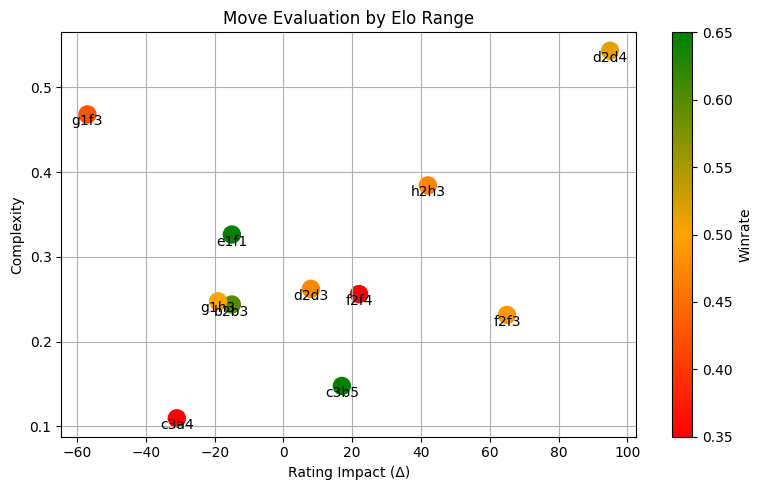

In [24]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("RG", ["red", "orange", "green"])
norm = mpl.colors.Normalize(vmin=0.35, vmax=0.65)

plt.figure(figsize=(8, 5))
sc = plt.scatter(
    df_result['delta'],
    df_result['complexity'],
    c=df_result['winrate_total'],
    cmap=cmap,
    norm=norm,
    s=150
)

for _, row in df_result.iterrows():
    plt.text(
        row['delta'],
        row['complexity'],
        row['next_move'],
        fontsize=10,
        ha='center',
        va='top'
    )

plt.colorbar(sc, label='Winrate')
plt.xlabel("Rating Impact (Δ)")
plt.ylabel("Complexity")
plt.title("Move Evaluation by Elo Range")
plt.grid(True)
plt.tight_layout()
plt.show()

# Todo
* Grafik fixen + Scaling anpassen, das ist teilweise noch negativ, also wird wohl noch falsch berechnet
* Was der Baum ist: Durchschnittliche Elo auch interessant, jeweils die drei am häufigsten gespielten Züge, damit nicht zu überladen und noch lesbar
* passt der baum mit winrate oder sollte man auf winrate verzichten und nur auf berwertung der stellung schauen?
* vielleicht winrate nicht als entscheidungskriterium und dann als train test datensatz für z.B. 1000 stellungen ausführen und schauen ob der beste ausgewählte zug auch die höchste winrate bringt [falls ich das so mache --> winrate für elo oder gesamte??]; besten zug, der aber nicht zu komplex ist
* Macht winrate für weiß sinn? gerade beim min max scaler ja eigentlich nicht oder? weil eigentlich müsste man die zugverbesserung aus pov nehmen und daheraus entscheiden
* Komplexität vs. winrate --> ist die komplexität nicht eigentlich egal wenn der zug für eine gewisse elo in der vergangenheit sehr gute ergebnisse gelierfert hat??
* Ähnlichkeit zum Engine-Best ... sehr oft der gleiche Zug, nur falls sehr kompliziert, gibt es abweichungen
* Engine-Best auswahl teilweise komisch, da es manchmal züge mit höheren bewertungen gibt, die auch noch leichter zu spielen sind --> liegt das an Zeitbeschränkung der Suche des besten Zuges? Wie wird der beste Zug ermittelt?
* Problem: Für manche Züge zu wenige Daten, wenn nicht in exakt gleicher Stellung zuvor gespielt: prefix durch fen austauschen!!!!!!!
* Wie sieht es aus mit Quellen? Weil bisher halt effektiv 1 Quelle? Wird erwartet, dass es deutlich mehr sind 2 pro absatz mäßige
* AKTUELL WIRD IMMER AUS SICHT VON WEIß INTERPRETIERT; DAS IST QUATSCH
* Data Sparsity in Lower/Upper Elo Brackets;;;; Player Behavior and Error Patterns Across Elo Levels
* irgendwie nochmal sicherstellen, dass der count hoch genug ist, sonst neuen zug ziehen
* ChatGPT zum schreiben von text? Exotischere wörter checkt man halt direkt
* in themenbeschreibung das paper ist zu sequence models: was ist das rschauen? --> fragen: soll ich das thematisieren, glaub eher net oder